In [1]:
import os
import argparse
import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

from model.ast_models import ASTModel
from model.wavenet import WaveNet
from model.Discriminator import JCUDiscriminator
from model.JCU_MSD import JCU_MSD

from Dataset.dataset import load_LJSpeech
from utils.tools import get_configs_of
%matplotlib inline

### Dataset

In [2]:
# train_loader = load_LJSpeech('Dataset/pitch_scaling.txt')
train_loader = load_LJSpeech('Dataset/pitch_scaling_spk_joint.txt', speaker_emb=True, joint_factor=True)

D:\MyPython_file\pytorch_file\DDPM\A_PJ3\tacotron2\stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
D:\MyPython_file\pytorch_file\DDPM\A_PJ3\tacotron2\layers.py:50: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=128, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [3]:
len(train_loader)

7907

### Model

In [2]:
input_tdim = 500
ast_mdl = ASTModel(label_dim=1,
                    fshape=128, tshape=2, fstride=128, tstride=1,
                    input_fdim=128, input_tdim=input_tdim, model_size='base',
                    pretrain_stage=False, load_pretrained_mdl_path='./save_model/SSAST-Base-Frame-400.pth')
'''
ft10是AISHELL1+AISHELL3训练的
ast_mdl_11是仅用AISHELL3训练的
'''
state_dict = torch.load('./save_model/ft10.pth')
ast_mdl.load_state_dict(state_dict, strict=False)
ast_mdl = ast_mdl.cuda()

now load a SSL pretrained models from ./save_model/SSAST-Base-Frame-400.pth
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=512
pretraining number of patches=512
fine-tuning patch split stride: frequncey=128, time=1
fine-tuning number of patches=499


D:\anaconda\envs\pytorch19\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [3]:
print(ast_mdl)

ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(128, 2), stride=(128, 1))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768

In [3]:
G = WaveNet(gin_channels=1, upsample_conditional_features=True).cuda()
state_dict = torch.load('./save_model/G_213.pth') #47 is the best
G.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [5]:
preprocess_config, model_config, train_config = get_configs_of('AISHELL')

In [6]:
# D = JCUDiscriminator(preprocess_config, model_config, train_config).cuda()
# state_dict = torch.load('./save_model/D_114.pth')
# D.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [5]:
D = JCU_MSD().cuda()
state_dict = torch.load('./save_model/D_209.pth')
D.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [3]:
print(D)

JCU_MSD(
  (input_proj): LinearNorm(
    (linear): Linear(in_features=128, out_features=256, bias=False)
  )
  (discriminators): ModuleList(
    (0): JCUD(
      (conv_group): ModuleList(
        (0): Sequential(
          (0): ConvNorm(
            (conv): Conv1d(256, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          )
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): Sequential(
          (0): ConvNorm(
            (conv): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
          )
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (2): Sequential(
          (0): ConvNorm(
            (conv): Conv1d(128, 512, kernel_size=(5,), stride=(2,), padding=(2,))
          )
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (3): Sequential(
          (0): ConvNorm(
            (conv): Conv1d(512, 128, kernel_size=(5,), stride=(1,), padding=(2,))
          )
          (1): LeakyReLU(negati

### Loss & OPT

In [5]:
loss_fn = nn.MSELoss()
# loss_fn1 = nn.L1Loss()
# loss_fn2 = nn.BCELoss()
opt_A = torch.optim.Adam(ast_mdl.parameters(),
                lr=0.0001,
                betas=(0.9, 0.99))
# opt_G = torch.optim.Adam(G.parameters(),
#                 lr=0.00005,
#                 betas=(0.9, 0.99))
# opt_D = torch.optim.Adam(D.parameters(),
#                 lr=0.0001,
#                 betas=(0.9, 0.99))

In [6]:
def model_update(model, step, loss, optimizer):
    grad_acc_step = 1
    grad_clip_thresh = 1
    # Backward
    loss = (loss / grad_acc_step).backward()
    if step % grad_acc_step == 0:
        # Clipping gradients to avoid gradient explosion
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip_thresh)

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

In [7]:
def weights_nonzero_speech(target):
    # target : B x T x mel
    # Assign weight 1.0 to all labels except for padding (id=0).
    dim = target.size(-1)
    return target.abs().sum(-1, keepdim=True).ne(0).float().repeat(1, 1, dim)

In [8]:
def get_mel_loss(mel_predictions, mel_targets):
    mel_targets.requires_grad = False
    # mel_predictions = mel_predictions.masked_fill(self.mel_masks_fill.unsqueeze(-1), 0)
    # mel_targets = mel_targets.masked_fill(self.mel_masks_fill.unsqueeze(-1), 0)
    mel_loss = l1_loss(mel_predictions, mel_targets)
    return mel_loss

def l1_loss(decoder_output, target):
    # decoder_output : B x T x n_mel
    # target : B x T x n_mel
    l1_loss = F.l1_loss(decoder_output, target, reduction="none")
    weights = weights_nonzero_speech(target)
    l1_loss = (l1_loss * weights).sum() / weights.sum()
    return l1_loss

#### Old loss

In [9]:
def discriminator_loss(disc_real_outputs, disc_fake_outputs):
    loss = 0
    for dr, dg in zip(disc_real_outputs, disc_fake_outputs):
        r_loss = F.mse_loss(dr[-1], torch.ones_like(dr[-1]), reduction="mean")
        g_loss = F.mse_loss(dg[-1], torch.zeros_like(dg[-1]), reduction="mean")
        loss += (r_loss + g_loss)  
    return loss

In [10]:
def generator_loss(disc_fake_outputs):
    loss = 0
    for dg in disc_fake_outputs:
        g_loss = F.mse_loss(dg[-1], torch.ones_like(dg[-1]), reduction="mean")
        loss += g_loss
    return loss

In [11]:
def get_fm_loss(disc_real_outputs, disc_fake_outputs):
    loss = 0
    for dr, dg in zip(disc_real_outputs, disc_fake_outputs):
        for j in range(len(dr[0]) - 1):
            loss += F.l1_loss(dr[0][j].detach(), dg[0][j])
    return loss

#### New loss

In [11]:
def jcu_loss_fn(logit_cond, logit_uncond, label_fn):
    cond_loss = F.mse_loss(logit_cond, label_fn(logit_cond), reduction="mean")
    uncond_loss = F.mse_loss(logit_uncond, label_fn(logit_uncond), reduction="mean")
    return 0.5 * (cond_loss + uncond_loss)

In [12]:
def discriminator_loss(disc_real_cond, disc_real_uncond, disc_fake_cond, disc_fake_uncond):
    r_loss = jcu_loss_fn(disc_real_cond[-1], disc_real_uncond[-1], torch.ones_like)
    g_loss = jcu_loss_fn(disc_fake_cond[-1], disc_fake_uncond[-1], torch.zeros_like)
    return r_loss + g_loss

In [13]:
def generator_loss(disc_fake_cond, disc_fake_uncond):
    g_loss = jcu_loss_fn(disc_fake_cond[-1], disc_fake_uncond[-1], torch.ones_like)
    return g_loss

In [14]:
def get_fm_loss(disc_real_cond, disc_real_uncond, disc_fake_cond, disc_fake_uncond):
    loss_fm = 0
    n_layers = 3
    feat_weights = 4.0 / (n_layers + 1)
    for j in range(len(disc_fake_cond) - 1):
        loss_fm += feat_weights * 0.5 * (F.l1_loss(disc_real_cond[j].detach(), disc_fake_cond[j]) \
                                         + F.l1_loss(disc_real_uncond[j].detach(), disc_fake_uncond[j]))
    return loss_fm

In [15]:
def hyber_loss():
    loss = L1 + ssim
    return loss

#### Visual

In [6]:
from scipy.io.wavfile import read
from tacotron2.layers import TacotronSTFT

target_length = 500

def load_wav_to_torch(full_path):
    """
    Loads wavdata into torch array
    """
    sampling_rate, data = read(full_path)
    return torch.from_numpy(data).float(), sampling_rate


stft = TacotronSTFT(filter_length=1024,
                    hop_length=256,
                    win_length=1024,
                    sampling_rate=22050,
                    mel_fmin=0, mel_fmax=8000)
   
def get_mel(audio, sr):
    audio_norm = audio / 32768.0
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0).T
    '''
     mel = (D, T)
    '''
        
#     #cut and pad
#     target_length = target_length
    # n_frames = melspec.shape[0]
    # p = target_length - n_frames
    # if p > 0:
    #     m = torch.nn.ZeroPad2d((0, 0, 0, p))
    #     melspec = m(melspec)
    # elif p < 0:
    #     melspec = melspec[0:target_length, :]       
            
    return melspec


def get_mel_a(audio, sr):
    audio_norm = audio / 32768.0
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0).T
    '''
     mel = (D, T)
    '''
        
    #cut and pad
    n_frames = melspec.shape[0]
    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        melspec = m(melspec)
    elif p < 0:
        melspec = melspec[0:target_length, :]       
            
    return melspec

D:\MyPython_file\pytorch_file\DDPM\A_PJ3\tacotron2\stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
D:\MyPython_file\pytorch_file\DDPM\A_PJ3\tacotron2\layers.py:50: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=128, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [7]:
def generate_images(model, path):
    sr, audio = load_wav_to_torch(path)
    alpha = torch.tensor([[-5.801]]).cuda()
    mel_s = get_mel(audio, sr).unsqueeze(0).cuda()
    reconstrant = model(mel_s.transpose(2,1), g=-alpha).transpose(2,1)

    plt.figure(figsize=(12, 12), dpi=300)
    display_list = [mel_s, reconstrant]
    title = ['Input Mel', 'Reconstrant Mel']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

#### Work train step

In [17]:
def train_joint(num_eps):
    for eps in range(num_eps):
        i = 0
        # ast_mdl.train()
        # G.train()
        # D.train()
        since = time.time()
        # loss_train, loss_valid = [], []
        loss_A, loss_adv, loss_fm, loss_spec, loss_G, loss_D = [], [], [], [], [], []
        #training phase
        for i, (fbank_s, fbank_o, label) in enumerate(train_loader): #fbank: [B, D, T];          
            fbank_s = fbank_s.cuda()
            fbank_o = fbank_o.cuda()
            label = label.cuda().unsqueeze(-1)
            # print(fbank_s.shape)
            # # print(fbank_o.shape)
            # # if i == 0:
            # plt.figure(figsize=(4, 4),dpi=100)
            # plt.imshow(fbank_s[0].T.detach().squeeze(0).cpu())   
            # plt.imshow(fbank_o[0].T.detach().squeeze(0).cpu())
            # #warming up
            # if global_step <= 1000 and global_step % 50 == 0 and args.warmup == True:
            #     for group_id, param_group in enumerate(optimizer.param_groups):
            #         warm_lr = (global_step / 1000) * lr_list[group_id]
            #         param_group['lr'] = warm_lr
            #         print('warm-up learning rate is {:f}'.format(param_group['lr']))
                    
            #calculate       
            # pred_alpha = ast_mdl(fbank_s, task='ft_cls').detach()
            # reco_fbank_s = G(fake_fbank_o.transpose(2,1), g=-pred_alpha).transpose(2,1)
            
            # opt_A.zero_grad()
            #loss
            #1.estimate loss
            # loss_tA = loss_fn(pred_alpha.float(), label.float())
            # loss_tA.backward() 
            # opt_A.step()
            
################################################################# 
            # for s in range(3):
            # pred_alpha = ast_mdl(fbank_s, task='ft_cls').detach()
            fake_fbank_o = G(fbank_s.transpose(2,1), g=-label.float()).transpose(2,1)
            D_real_cond, D_real_uncond = D(fbank_o)
            D_fake_cond, D_fake_uncond = D(fake_fbank_o.detach())
            
            
            # 1.adv loss D
            loss_tD = discriminator_loss(D_real_cond, D_real_uncond, D_fake_cond, D_fake_uncond)
            
            # upgrade D
            model_update(D, i, loss_tD, opt_D)
#################################################################
            # pred_alpha = ast_mdl(fbank_s, task='ft_cls').detach()
            fake_fbank_o = G(fbank_s.transpose(2,1), g=-label.float()).transpose(2,1)
            D_real_cond, D_real_uncond = D(fbank_o)
            D_fake_cond, D_fake_uncond = D(fake_fbank_o)
    
            #1.recon loss
            loss_recon = get_mel_loss(fake_fbank_o, fbank_o)

            #2.FM loss
            loss_FM = get_fm_loss(D_real_cond, D_real_uncond, D_fake_cond, D_fake_uncond)

            #3.adv loss G
            loss_advG = generator_loss(D_fake_cond, D_fake_uncond)           
              
            #total loss 
            lambda_FM = loss_recon.item() / loss_FM.item()     
            loss_tG = loss_advG + lambda_FM*loss_FM + loss_recon #
              
            #upgrade G       
            model_update(G, i, loss_tG, opt_G)
################################################################    
            #log    
#           loss_A.append(loss_total_A)
            loss_adv.append(loss_advG.mean().detach()) 
            loss_fm.append(loss_FM.mean().detach()) 
            loss_spec.append(loss_recon.mean().detach()) 
            loss_G.append(loss_tG.mean().detach())
            loss_D.append(loss_tD.mean().detach())

            if i % 32 == 0:
                print ('.', end='')
            i += 1
   
    
    
#         #valid phase
#         ast_mdl.eval()
#         for i, (fbank, label) in enumerate(valid_loader): #fbank: [B, D, T];    
#             fbank = fbank.cuda()
#             label = label.cuda().unsqueeze(-1)
              
#             pred_alpha = ast_mdl(fbank, task='ft_cls') 
#             loss = loss_fn(pred_alpha.float(), label.float())
#             loss_valid.append(loss)

#             if i % 32 == 0:
#                 print ('.', end='')
#             i += 1
        
        time_elapsed = time.time() - since    
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
        if eps % 1 == 0:
            print('loss_adv:', sum(loss_adv)/len(loss_adv), 'loss_fm:', sum(loss_fm)/len(loss_fm), 'loss_spec:', sum(loss_spec)/len(loss_spec),
                  'loss_G:', sum(loss_G)/len(loss_G), 'loss_D:', sum(loss_D)/len(loss_D)) 
            # print('loss_spec:', sum(loss_spec)/len(loss_spec))  
            
        # if eps % 1 == 0:    
        #     generate_images(G, 'E:/datasets/project3/AISHELL-3/scale2/SSB0758/SSB07580004_-5.801_.wav')
            
        if (eps + 1) % 5 == 0:
            torch.save(G.state_dict(), 'save_model/G_'+str(eps+100)+'.pth')
            print ('Saving checkpoint for epoch {} at {}'.format(eps+100,
                                                         'save_model/G_'+str(eps+100)+'.pth'))
            
            torch.save(D.state_dict(), 'save_model/D_'+str(eps+100)+'.pth')
            print ('Saving checkpoint for epoch {} at {}'.format(eps+100,
                                                         'save_model/G_'+str(eps+100)+'.pth'))

#### New train step

In [11]:
def train_joint(num_eps):
    for eps in range(num_eps):
        i = 0
        ast_mdl.train()
        # G.train()
        # D.train()
        since = time.time()
        # loss_train, loss_valid = [], []
        loss_A, loss_adv, loss_fm, loss_spec, loss_G, loss_D = [], [], [], [], [], []
        #training phase
        for i, (fbank_s, fbank_o, label) in enumerate(train_loader): #fbank: [B, D, T];          
            fbank_s = fbank_s.cuda()
            fbank_o = fbank_o.cuda()
            label = label.cuda().unsqueeze(-1)
            # print(fbank_s.shape)
            # # print(fbank_o.shape)
            # # if i == 0:
            # plt.figure(figsize=(4, 4),dpi=100)
            # plt.imshow(fbank_s[0].T.detach().squeeze(0).cpu())   
            # plt.imshow(fbank_o[0].T.detach().squeeze(0).cpu())
            # #warming up
            # if global_step <= 1000 and global_step % 50 == 0 and args.warmup == True:
            #     for group_id, param_group in enumerate(optimizer.param_groups):
            #         warm_lr = (global_step / 1000) * lr_list[group_id]
            #         param_group['lr'] = warm_lr
            #         print('warm-up learning rate is {:f}'.format(param_group['lr']))
                    
            #calculate       
            pred_alpha = ast_mdl(fbank_s, task='ft_cls')
            # reco_fbank_s = G(fake_fbank_o.transpose(2,1), g=-pred_alpha).transpose(2,1)

            # loss
            # 1.estimate loss
            loss_tA = loss_fn(pred_alpha.float(), label.float())
            
            # upgrade A
            model_update(ast_mdl, i, loss_tA, opt_A)
################################################################# 
            # for s in range(3):
            # pred_alpha = ast_mdl(fbank_s, task='ft_cls').detach()
#             fake_fbank_o = G(fbank_s.transpose(2,1), g=-label.float()).transpose(2,1)
#             D_real = D(fbank_o)
#             D_fake = D(fake_fbank_o.detach())
                   
#             # 1.adv loss D
#             loss_tD = discriminator_loss(D_real, D_fake)
            
#             # upgrade D
#             model_update(D, i, loss_tD, opt_D)
# #################################################################
#             # pred_alpha = ast_mdl(fbank_s, task='ft_cls').detach()
#             fake_fbank_o = G(fbank_s.transpose(2,1), g=-label.float()).transpose(2,1)
#             D_real = D(fbank_o)
#             D_fake = D(fake_fbank_o)
    
#             #1.recon loss
#             loss_recon = get_mel_loss(fake_fbank_o, fbank_o)

#             #2.FM loss
#             loss_FM = get_fm_loss(D_real, D_fake)

#             #3.adv loss G
#             loss_advG = generator_loss(D_fake)           
              
#             #total loss 
#             lambda_FM = loss_recon.item() / loss_FM.item()     
#             loss_tG = loss_advG + lambda_FM*loss_FM + loss_recon #
              
#             #upgrade G       
#             model_update(G, i, loss_tG, opt_G)
################################################################    
            #log    
            loss_A.append(loss_tA.mean().detach())
            # loss_adv.append(loss_advG.mean().detach()) 
            # loss_fm.append(loss_FM.mean().detach()) 
            # loss_spec.append(loss_recon.mean().detach()) 
            # loss_G.append(loss_tG.mean().detach())
            # loss_D.append(loss_tD.mean().detach())

            if i % 32 == 0:
                print ('.', end='')
            i += 1
   
    
    
#         #valid phase
#         ast_mdl.eval()
#         for i, (fbank, label) in enumerate(valid_loader): #fbank: [B, D, T];    
#             fbank = fbank.cuda()
#             label = label.cuda().unsqueeze(-1)
              
#             pred_alpha = ast_mdl(fbank, task='ft_cls') 
#             loss = loss_fn(pred_alpha.float(), label.float())
#             loss_valid.append(loss)

#             if i % 32 == 0:
#                 print ('.', end='')
#             i += 1
        
        time_elapsed = time.time() - since    
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
        if eps % 1 == 0:
            # print('loss_adv:', sum(loss_adv)/len(loss_adv), 'loss_fm:', sum(loss_fm)/len(loss_fm), 'loss_spec:', sum(loss_spec)/len(loss_spec),
            #       'loss_G:', sum(loss_G)/len(loss_G), 'loss_D:', sum(loss_D)/len(loss_D)) 
            print('loss_A:', sum(loss_A)/len(loss_A))  
            
        # if eps % 1 == 0:    
        #     generate_images(G, 'E:/datasets/project3/AISHELL-3/scale2/SSB0758/SSB07580004_-5.801_.wav')
            
        if (eps + 1) % 5 == 0:
            torch.save(ast_mdl.state_dict(), 'save_model/ast_mdl_'+str(eps)+'.pth')
            print ('Saving checkpoint for epoch {} at {}'.format(eps,
                                                         'save_model/ast_mdl_'+str(eps)+'.pth'))
#             torch.save(G.state_dict(), 'save_model/G_'+str(eps+209)+'.pth')
#             print ('Saving checkpoint for epoch {} at {}'.format(eps+209,
#                                                          'save_model/G_'+str(eps+209)+'.pth'))
            
#             torch.save(D.state_dict(), 'save_model/D_'+str(eps+209)+'.pth')
#             print ('Saving checkpoint for epoch {} at {}'.format(eps+209,
#                                                          'save_model/G_'+str(eps+209)+'.pth'))

In [12]:
num_epochs=99

In [13]:
train_joint(num_epochs)

........................................................................................................................................................................................................................................................Training complete in 80m 52s
loss_A: tensor(0.1200, device='cuda:0')
........................................................................................................................................................................................................................................................Training complete in 80m 59s
loss_A: tensor(0.0791, device='cuda:0')
........................................................................................................................................................................................................................................................Training complete in 81m 0s
loss_A: tensor(0.0638, device='cuda:0')
..................................................

KeyboardInterrupt: 

In [14]:
eps = 11
torch.save(ast_mdl.state_dict(), 'save_model/ast_mdl_'+str(eps)+'.pth')
print ('Saving checkpoint for epoch {} at {}'.format(eps,
                                                    'save_model/ast_mdl_'+str(eps)+'.pth'))

Saving checkpoint for epoch 11 at save_model/ast_mdl_11.pth


In [20]:
eps = 47
torch.save(G.state_dict(), 'save_model/G_'+str(eps)+'.pth')
print ('Saving checkpoint for epoch {} at {}'.format(eps,
                                                         'save_model/G_'+str(eps)+'.pth'))
            
torch.save(D.state_dict(), 'save_model/D_'+str(eps)+'.pth')
print ('Saving checkpoint for epoch {} at {}'.format(eps,
                                                         'save_model/G_'+str(eps)+'.pth'))

Saving checkpoint for epoch 47 at save_model/G_47.pth
Saving checkpoint for epoch 47 at save_model/G_47.pth


### val

In [131]:
audio, sr = load_wav_to_torch('E:/datasets/project3/AISHELL-3/unseen_praat/7.0/SSB06930023.wav')
mel_a = get_mel_a(audio, sr).unsqueeze(0).cuda()
mel_s = get_mel(audio, sr).unsqueeze(0).cuda()

In [123]:
audio, sr = load_wav_to_torch('D:/MyPython_file/pytorch_file/DDPM/A_PJ3/TD-PSOLA-master/SSB06930023_1.50.wav')
mel_a = get_mel_a(audio, sr).unsqueeze(0).cuda()
mel_s = get_mel(audio, sr).unsqueeze(0).cuda()

In [67]:
audio, sr = load_wav_to_torch('E:/datasets/project3/recover/SSB12390012_6.55.wav')
mel_a = get_mel_a(audio, sr).unsqueeze(0).cuda()
mel_s = get_mel(audio, sr).unsqueeze(0).cuda()

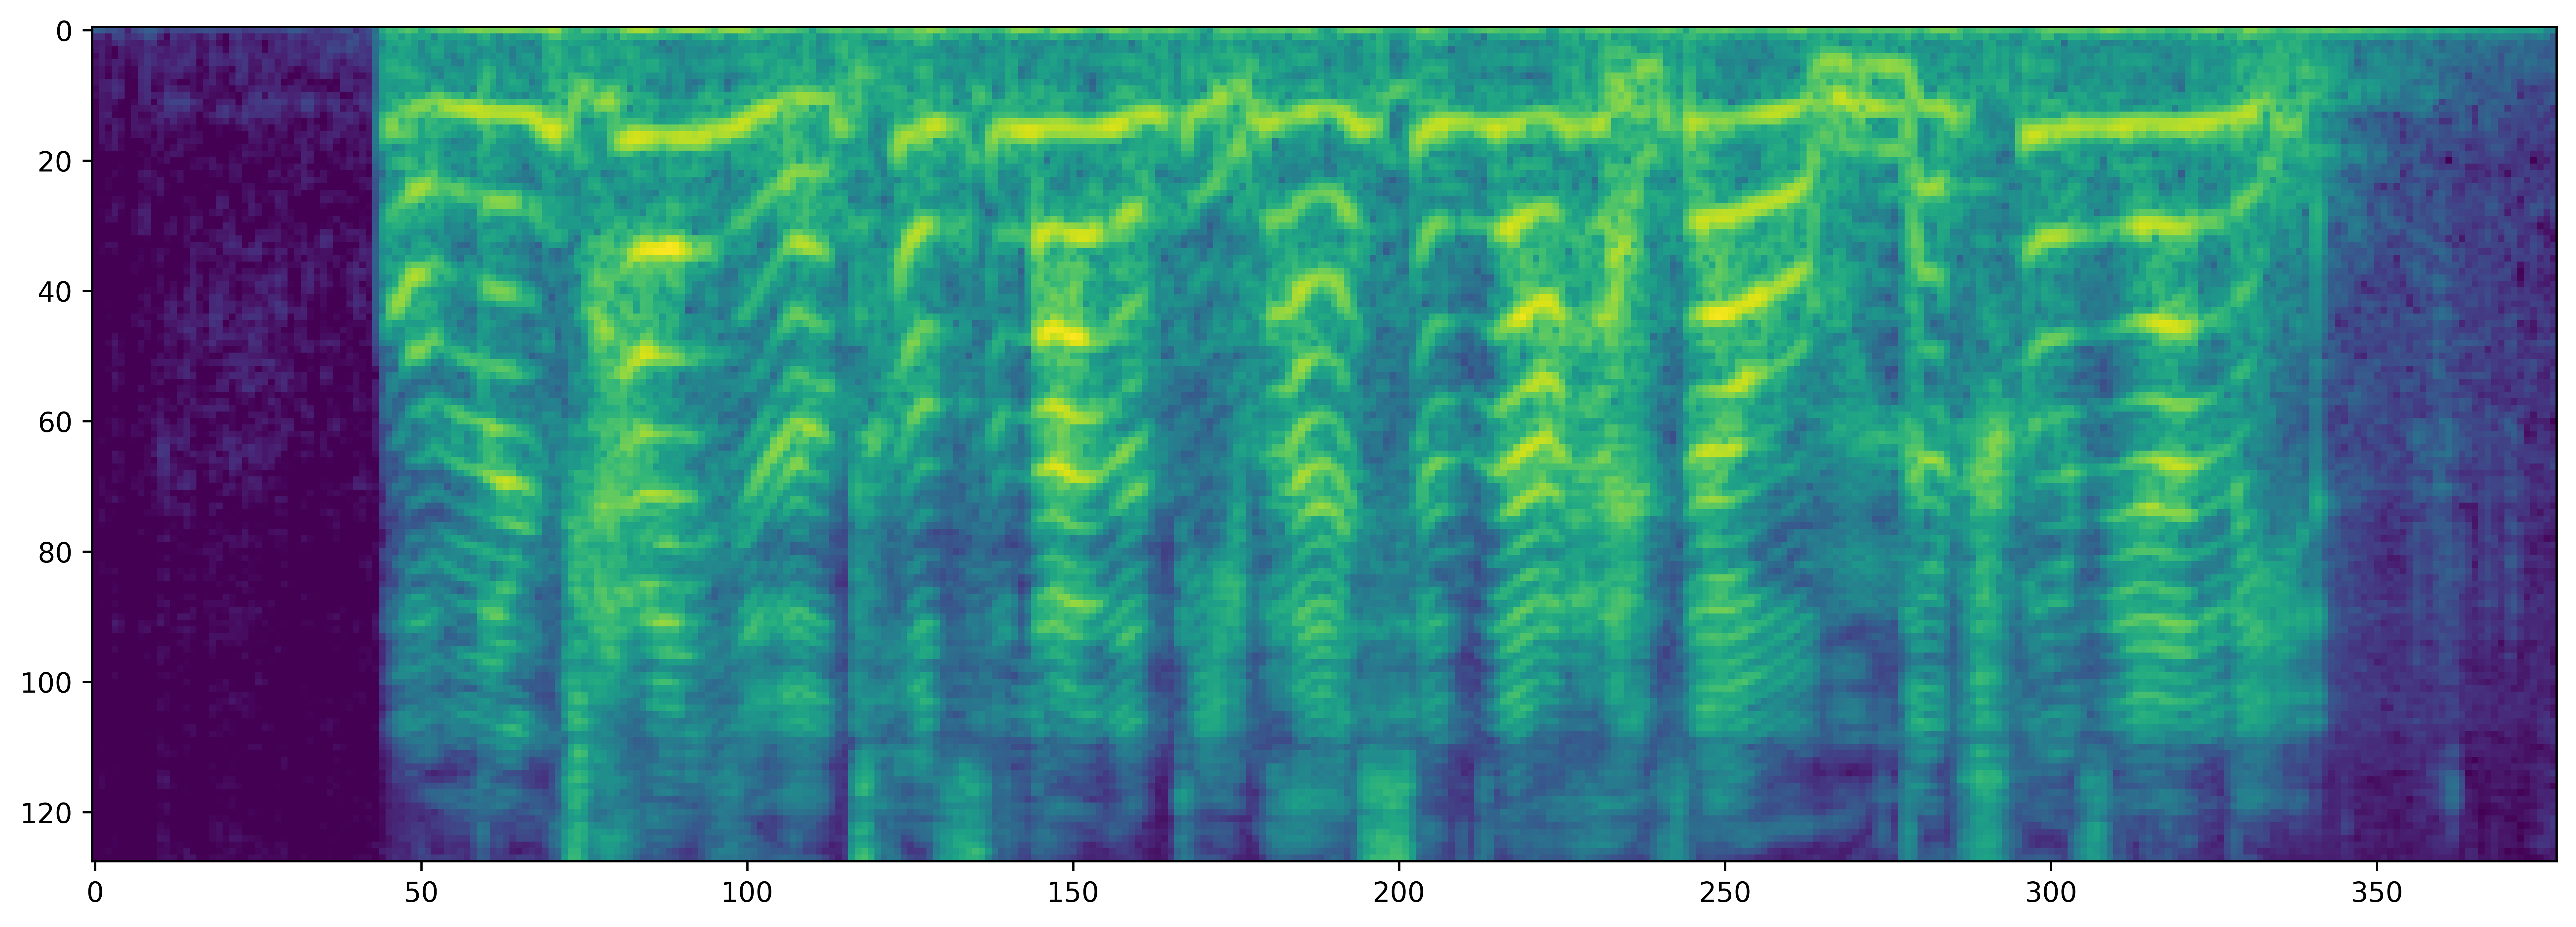

In [132]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(mel_s.T.squeeze(0).cpu())

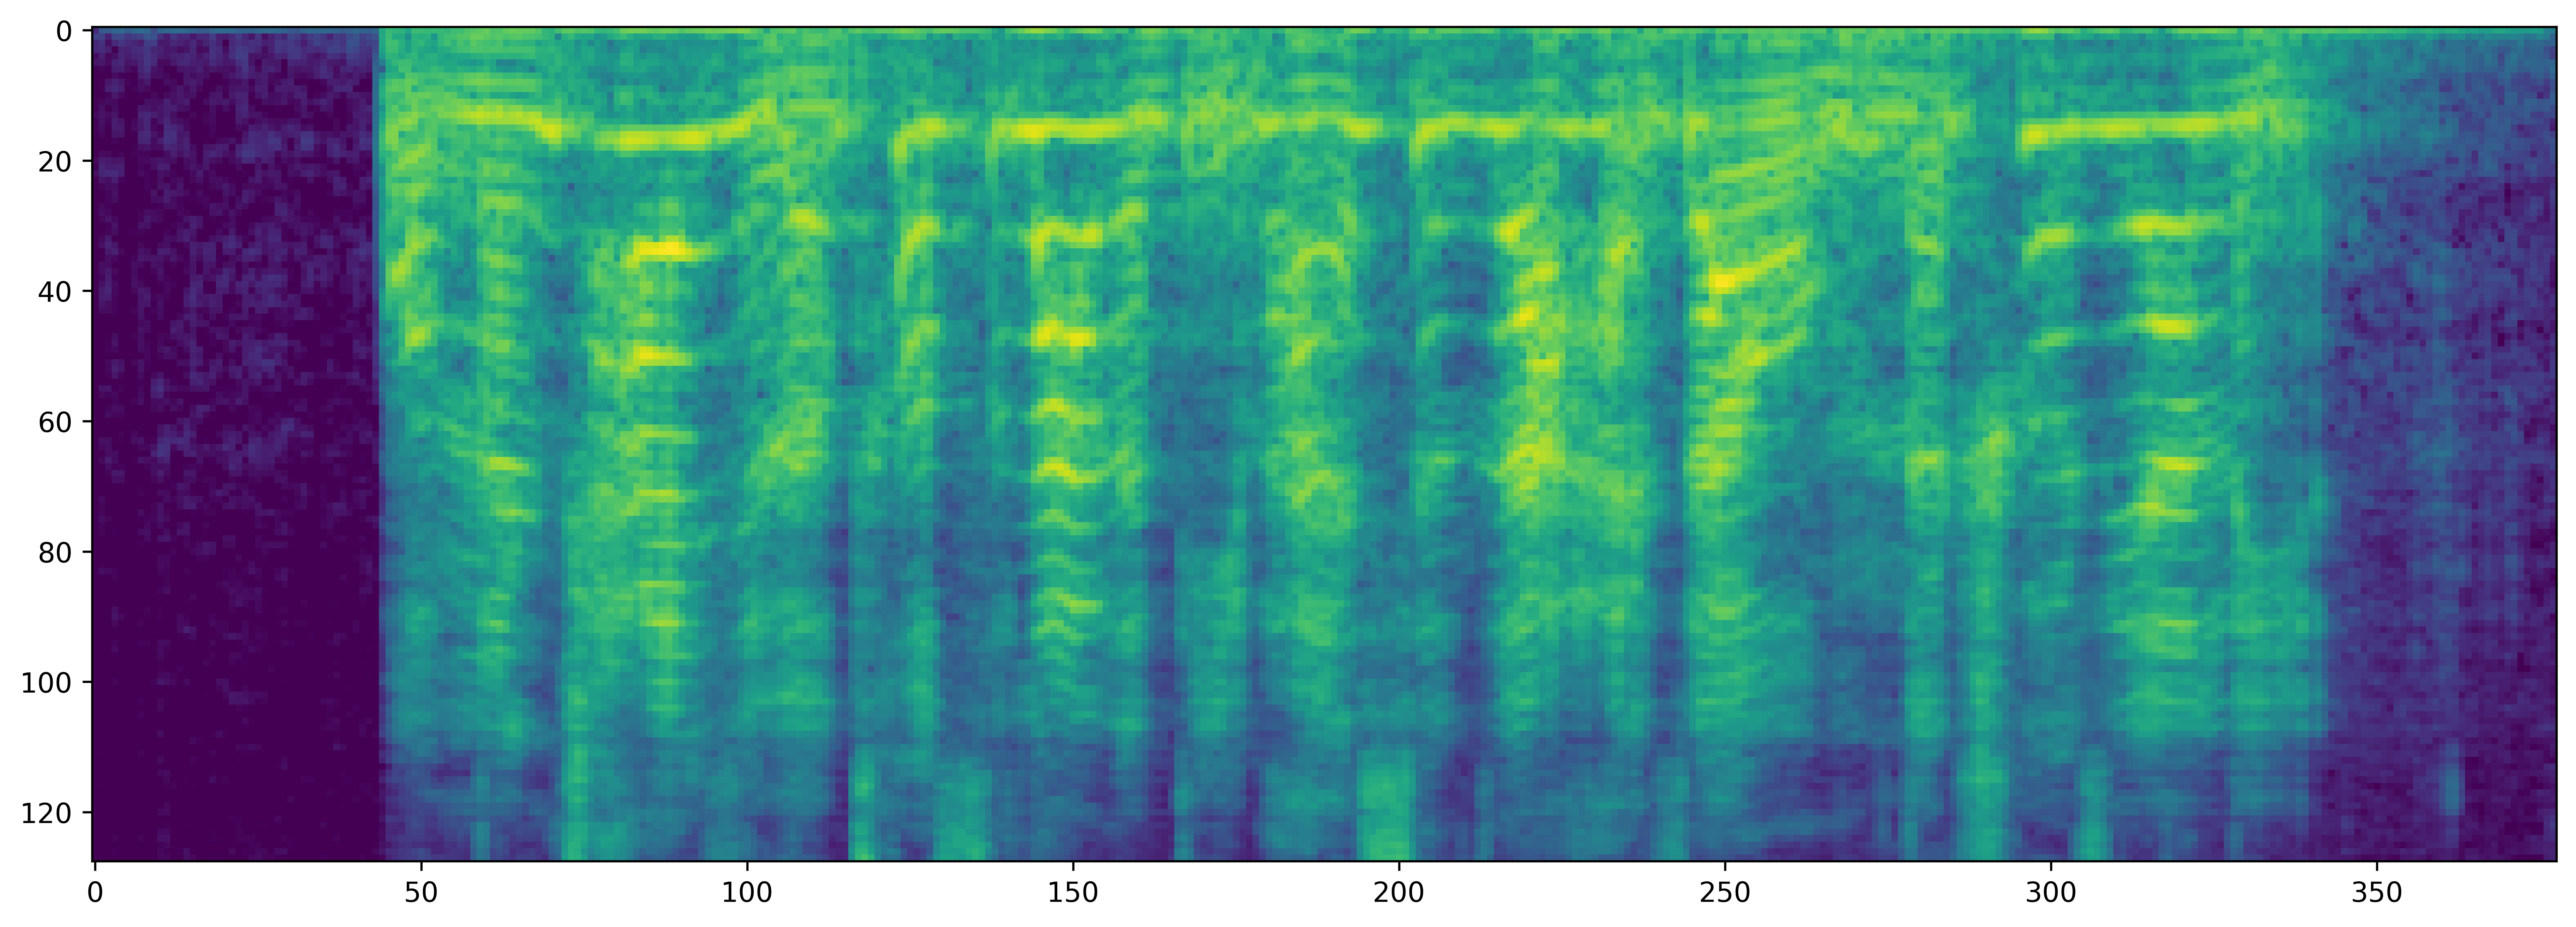

In [124]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(mel_s.T.squeeze(0).cpu())

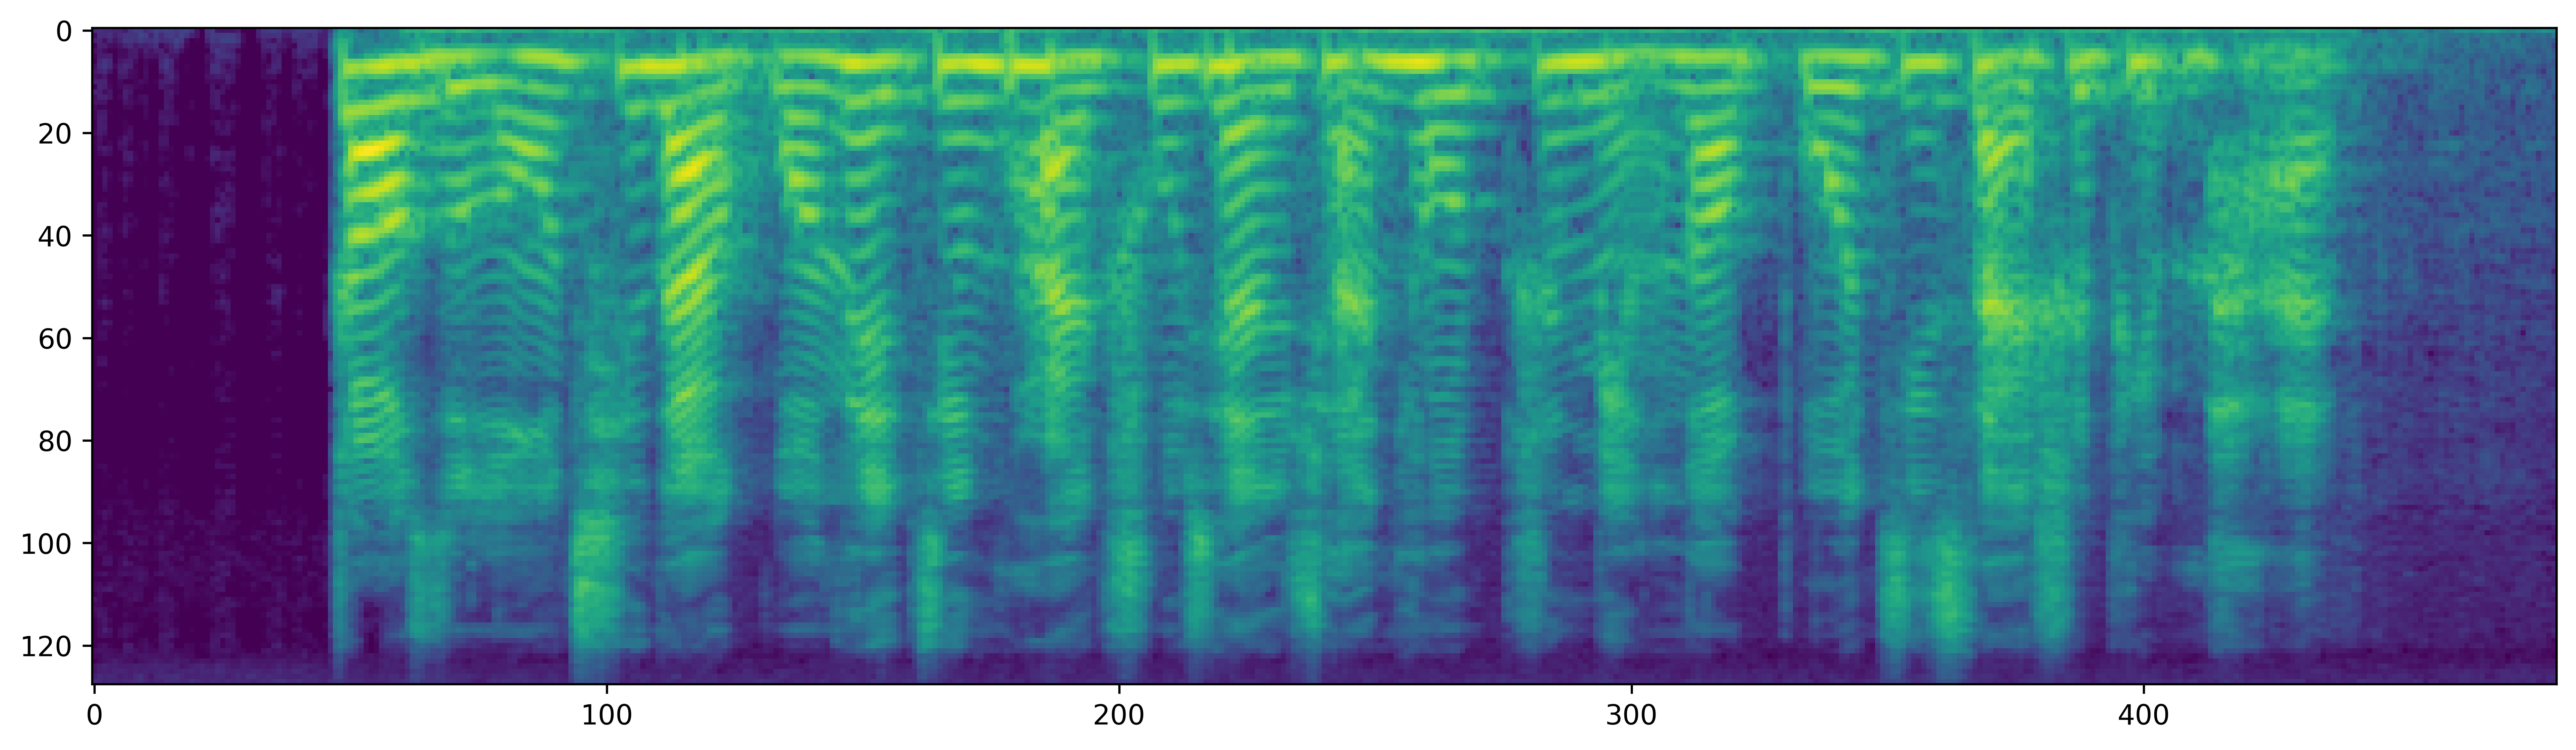

In [69]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(mel_s.T.squeeze(0).cpu())

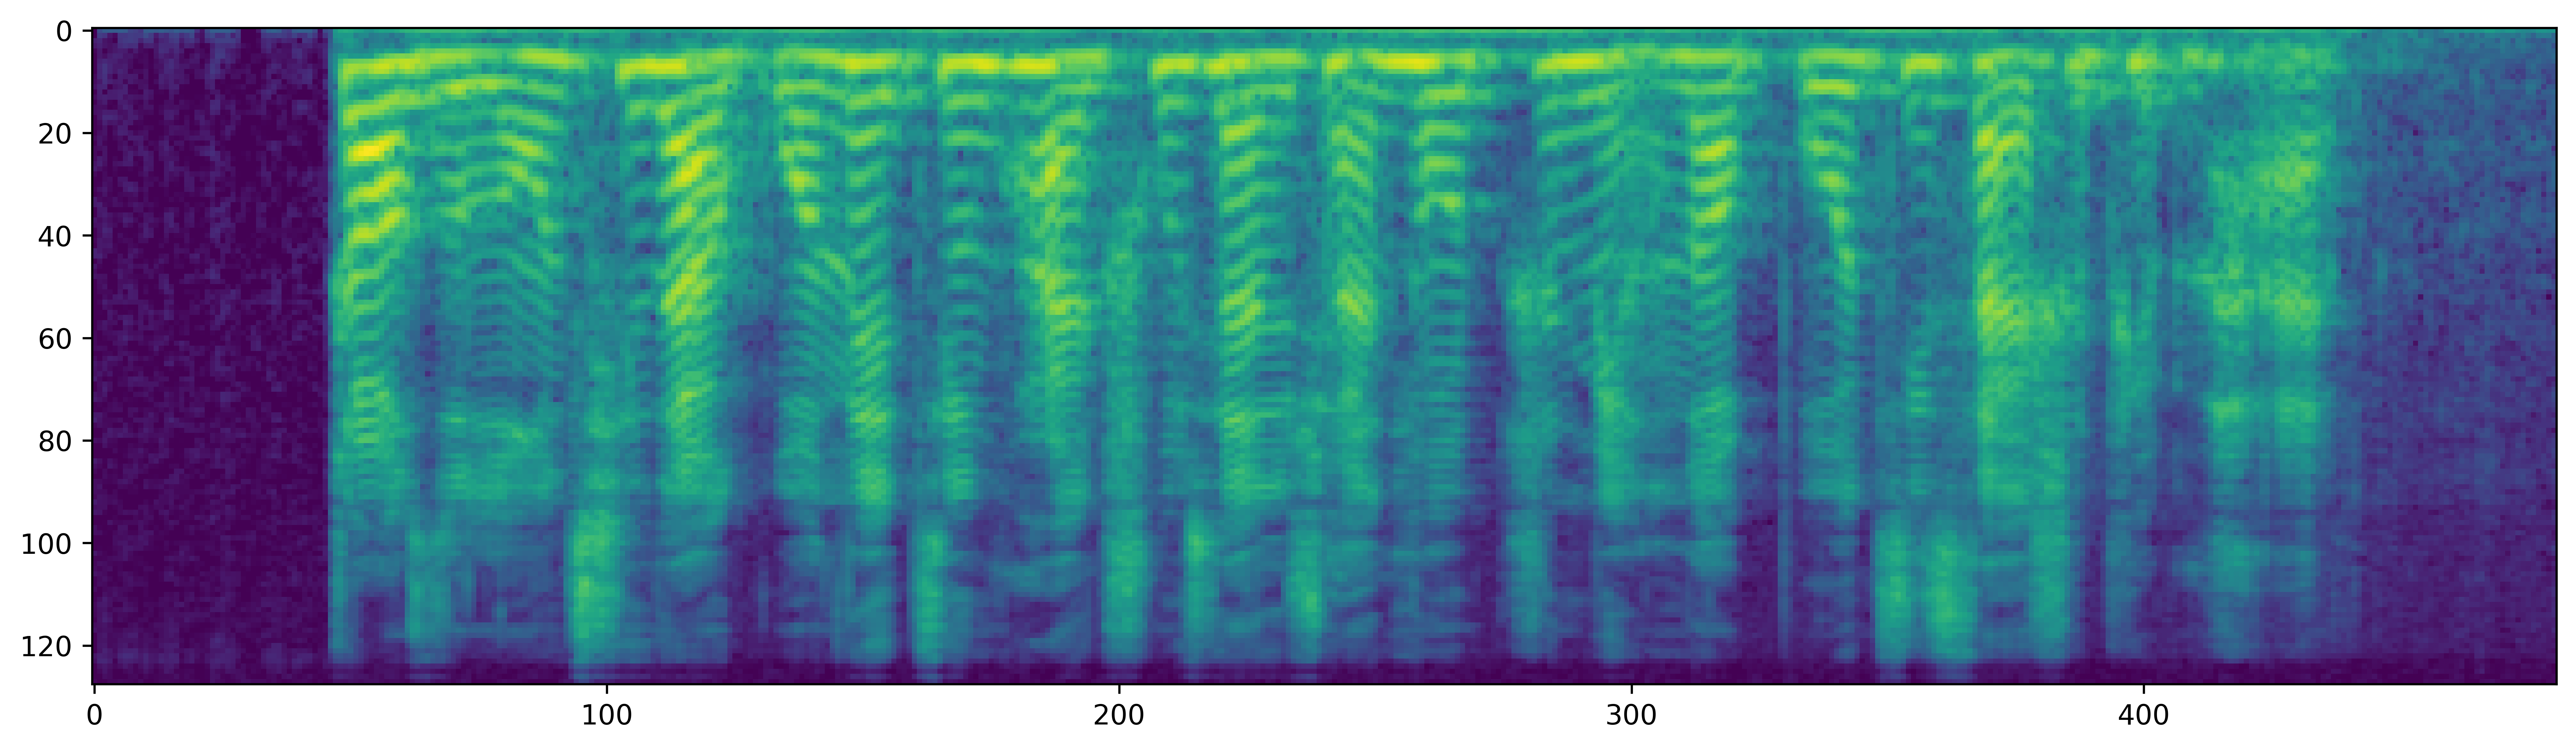

In [74]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(mel_s.T.squeeze(0).cpu())

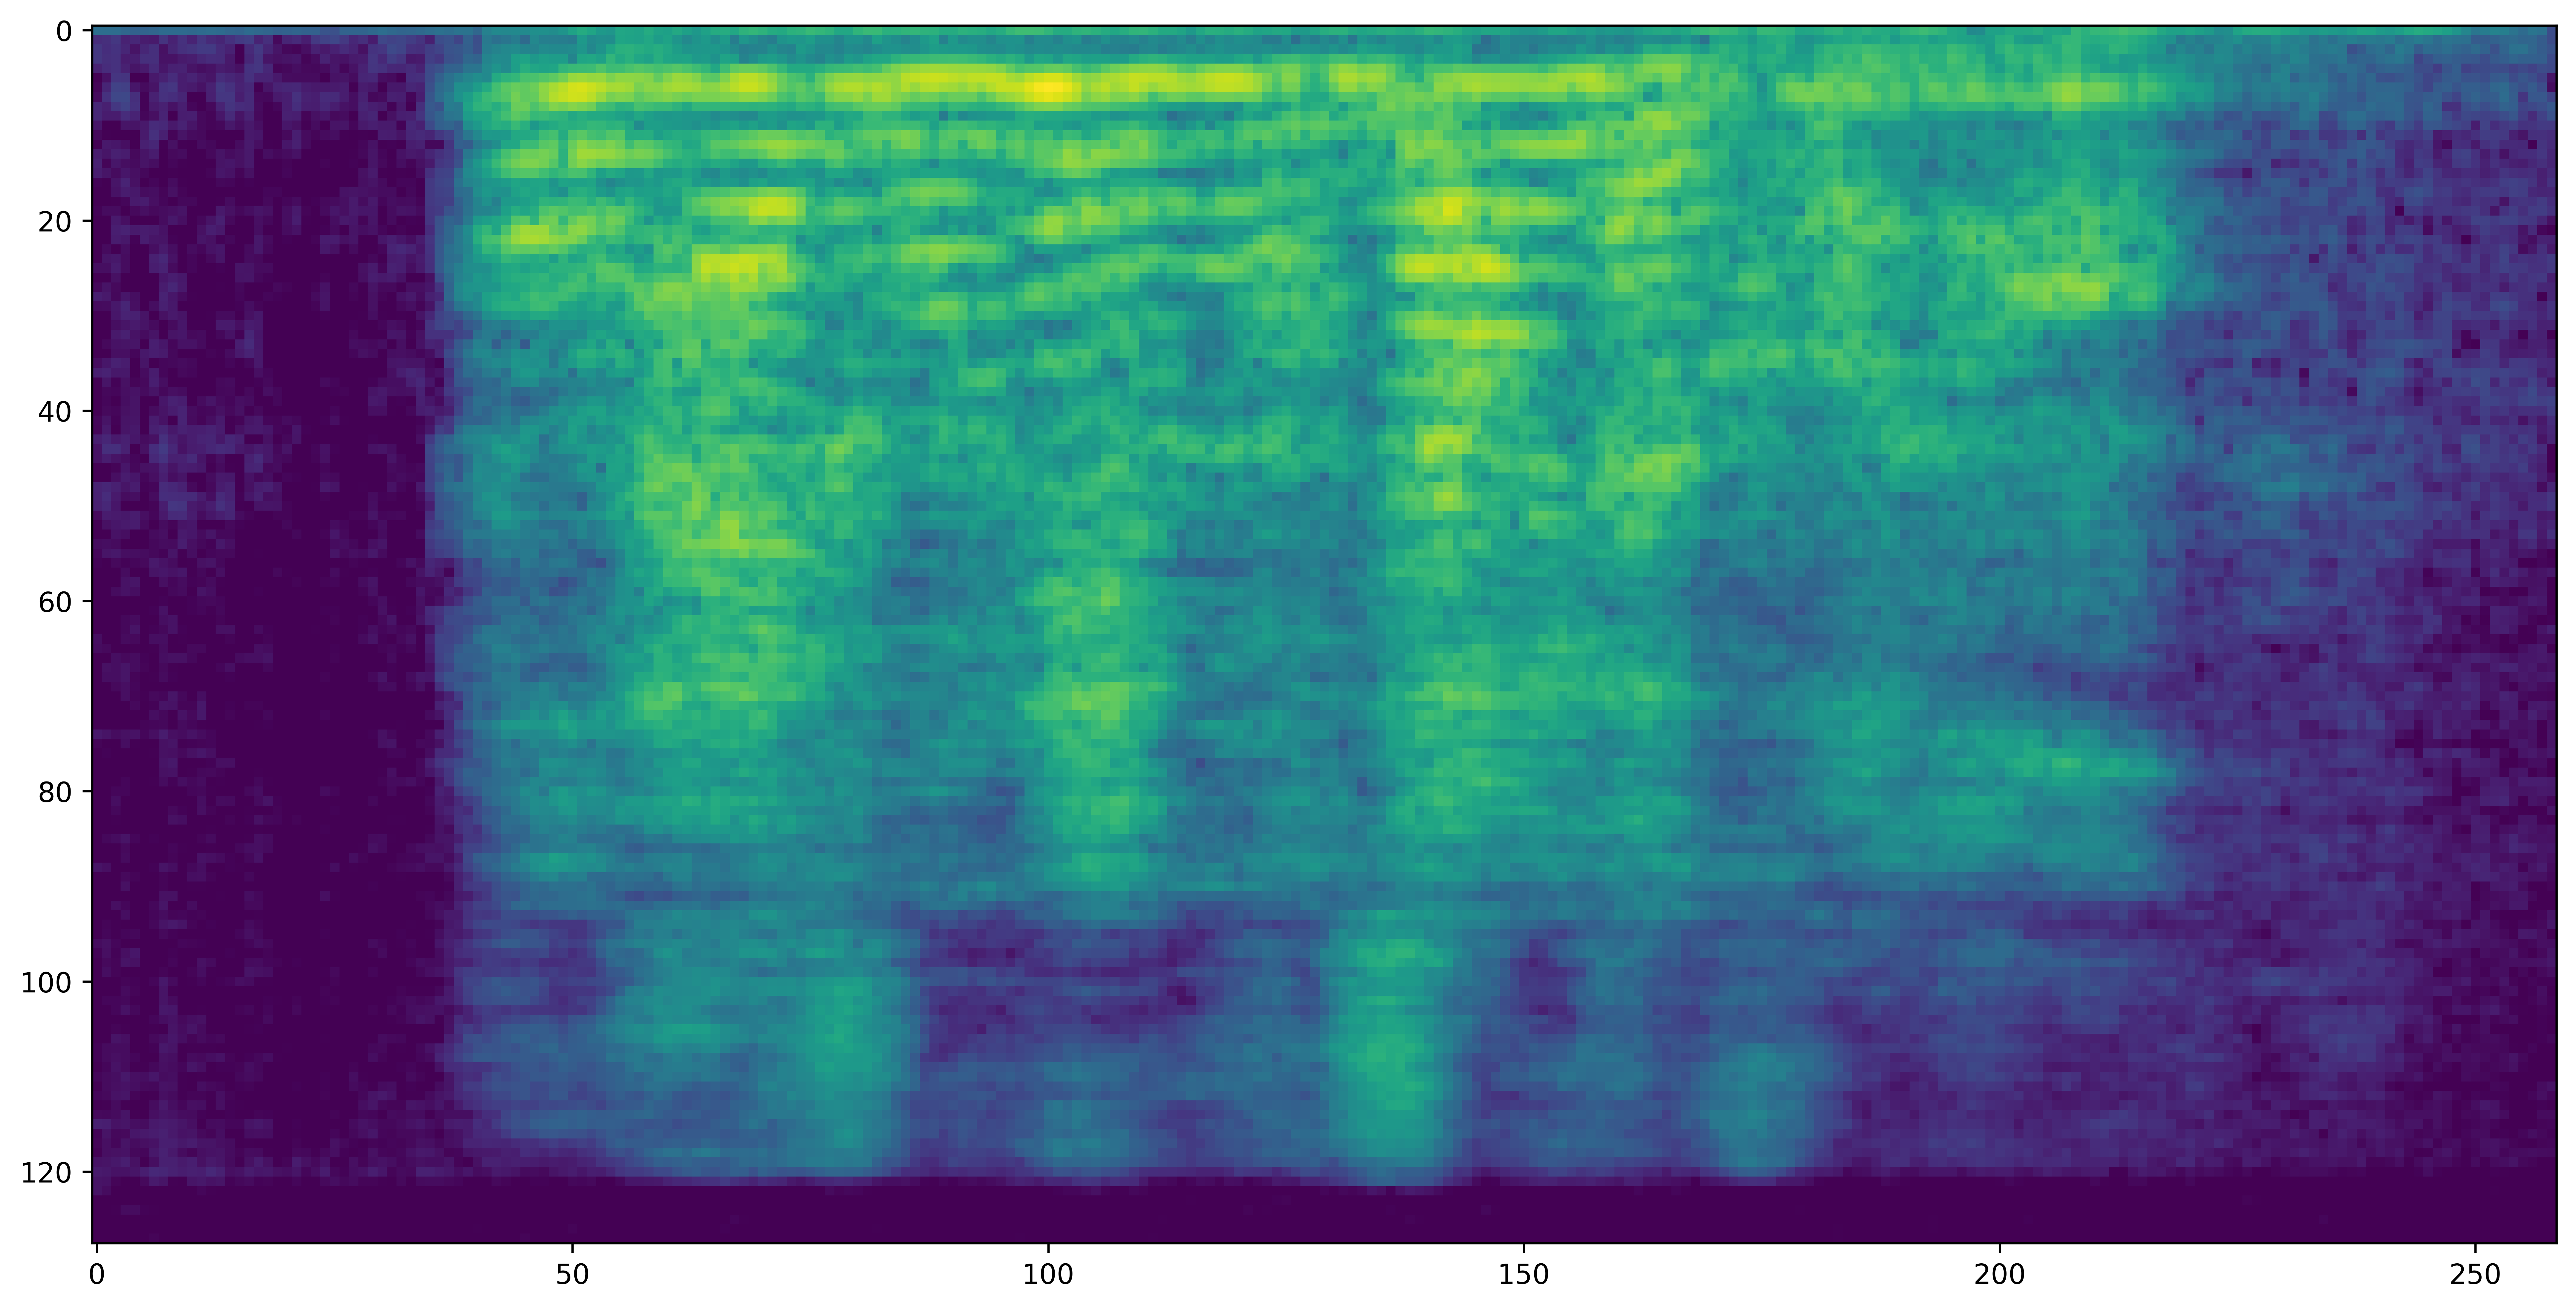

In [78]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(mel_s.T.squeeze(0).cpu())

### Block

In [188]:
m = mel_s.T.squeeze(-1).cpu()

In [189]:
m.shape[1]

814

In [190]:
m

tensor([[ -5.1812,  -4.6170,  -4.3780,  ...,  -3.7873,  -2.9467,  -2.5009],
        [ -5.0240,  -5.3360,  -5.4428,  ...,  -3.7932,  -3.4771,  -3.5572],
        [ -6.5008,  -5.8159,  -5.5412,  ...,  -4.7244,  -5.4330,  -6.1573],
        ...,
        [-10.3672, -10.2541, -10.5018,  ...,  -9.8461,  -9.6411,  -8.1436],
        [-10.1539,  -9.9543,  -9.8055,  ...,  -9.9224,  -9.7085,  -8.3005],
        [ -9.9277,  -9.9628, -10.0206,  ..., -10.3061,  -9.5624,  -8.0464]])

In [191]:
#随机抽k列出来，赋0
k = 0
for l in range(m.shape[1]):
    k = k+1
    if k%40 == 0:
        m[:,l:l+3]= -7

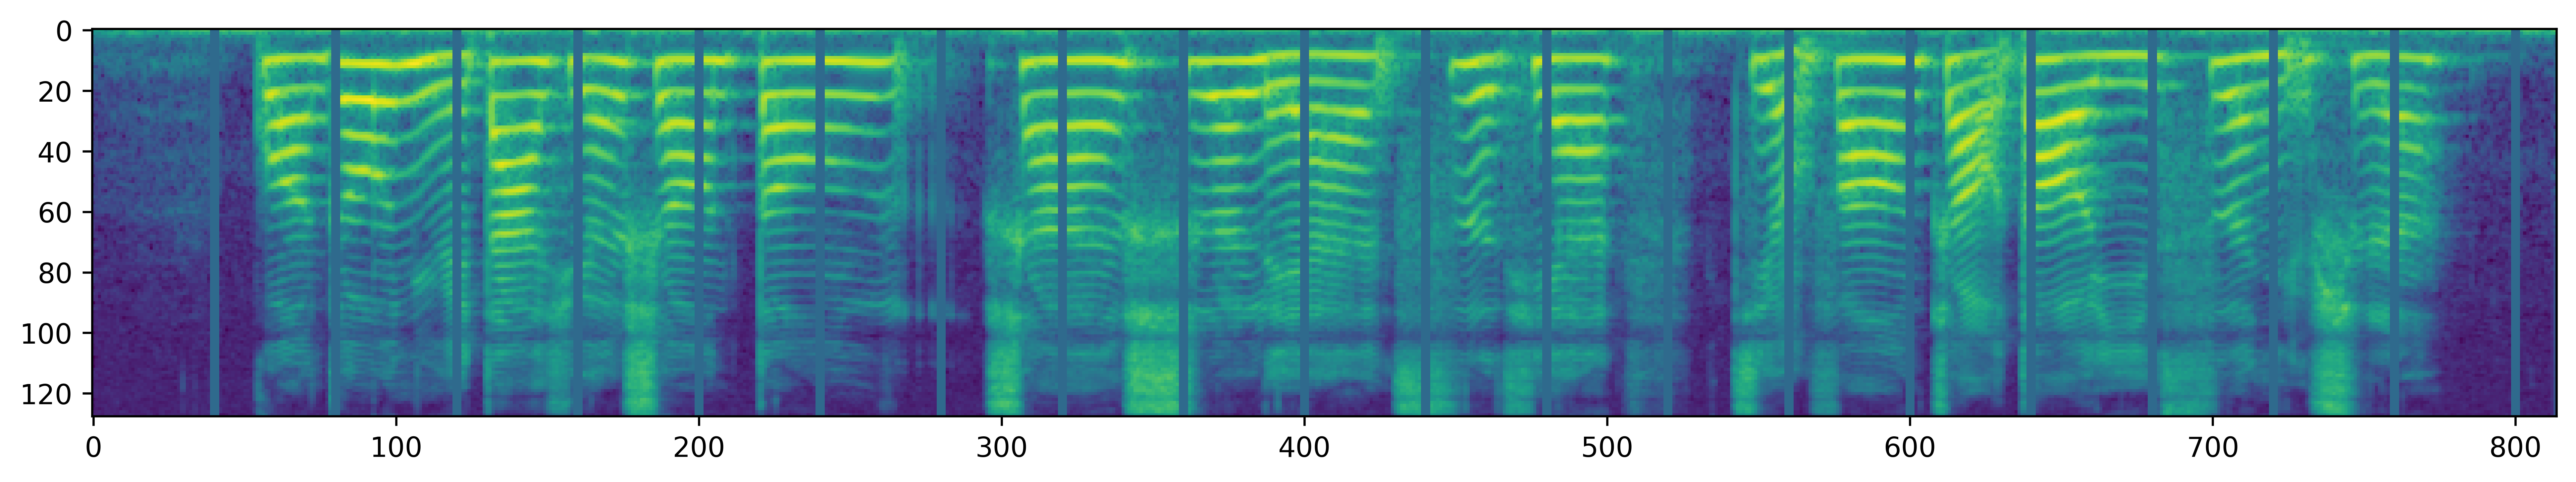

In [193]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(m)

In [194]:
torch.save(m, './00025.wav.pt')

### Test

In [125]:
ast_mdl = ast_mdl.()

In [126]:
alpha = ast_mdl(mel_a, task='ft_cls').detach()

In [127]:
alpha

tensor([[-0.0005]], device='cuda:0')

In [119]:
reconstrant = G(mel_s.transpose(2,1), g=-alpha).transpose(2,1)

In [120]:
reconstrant.shape

torch.Size([1, 755, 128])

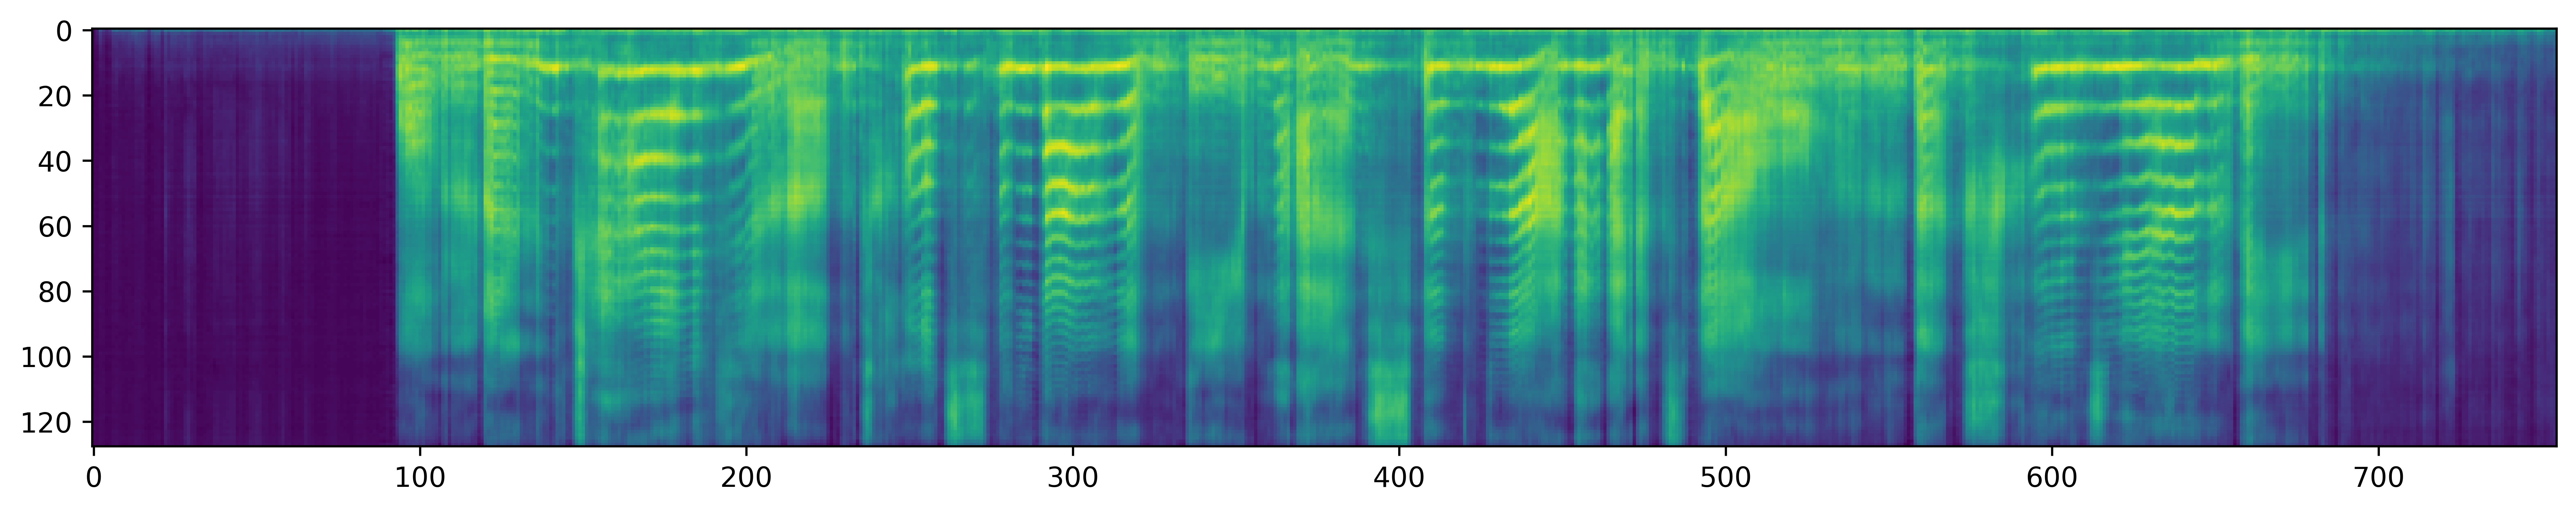

In [121]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(reconstrant.T.detach().squeeze(0).cpu())

In [122]:
torch.save(reconstrant.squeeze(0).T, './00028.wav.pt')

In [31]:
audio, sr = load_wav_to_torch('E:/datasets/project3/recover/SSB19560011.wav')
mel_a = get_mel_a(audio, sr).unsqueeze(0).cuda()
mel_s = get_mel(audio, sr).unsqueeze(0).cuda()

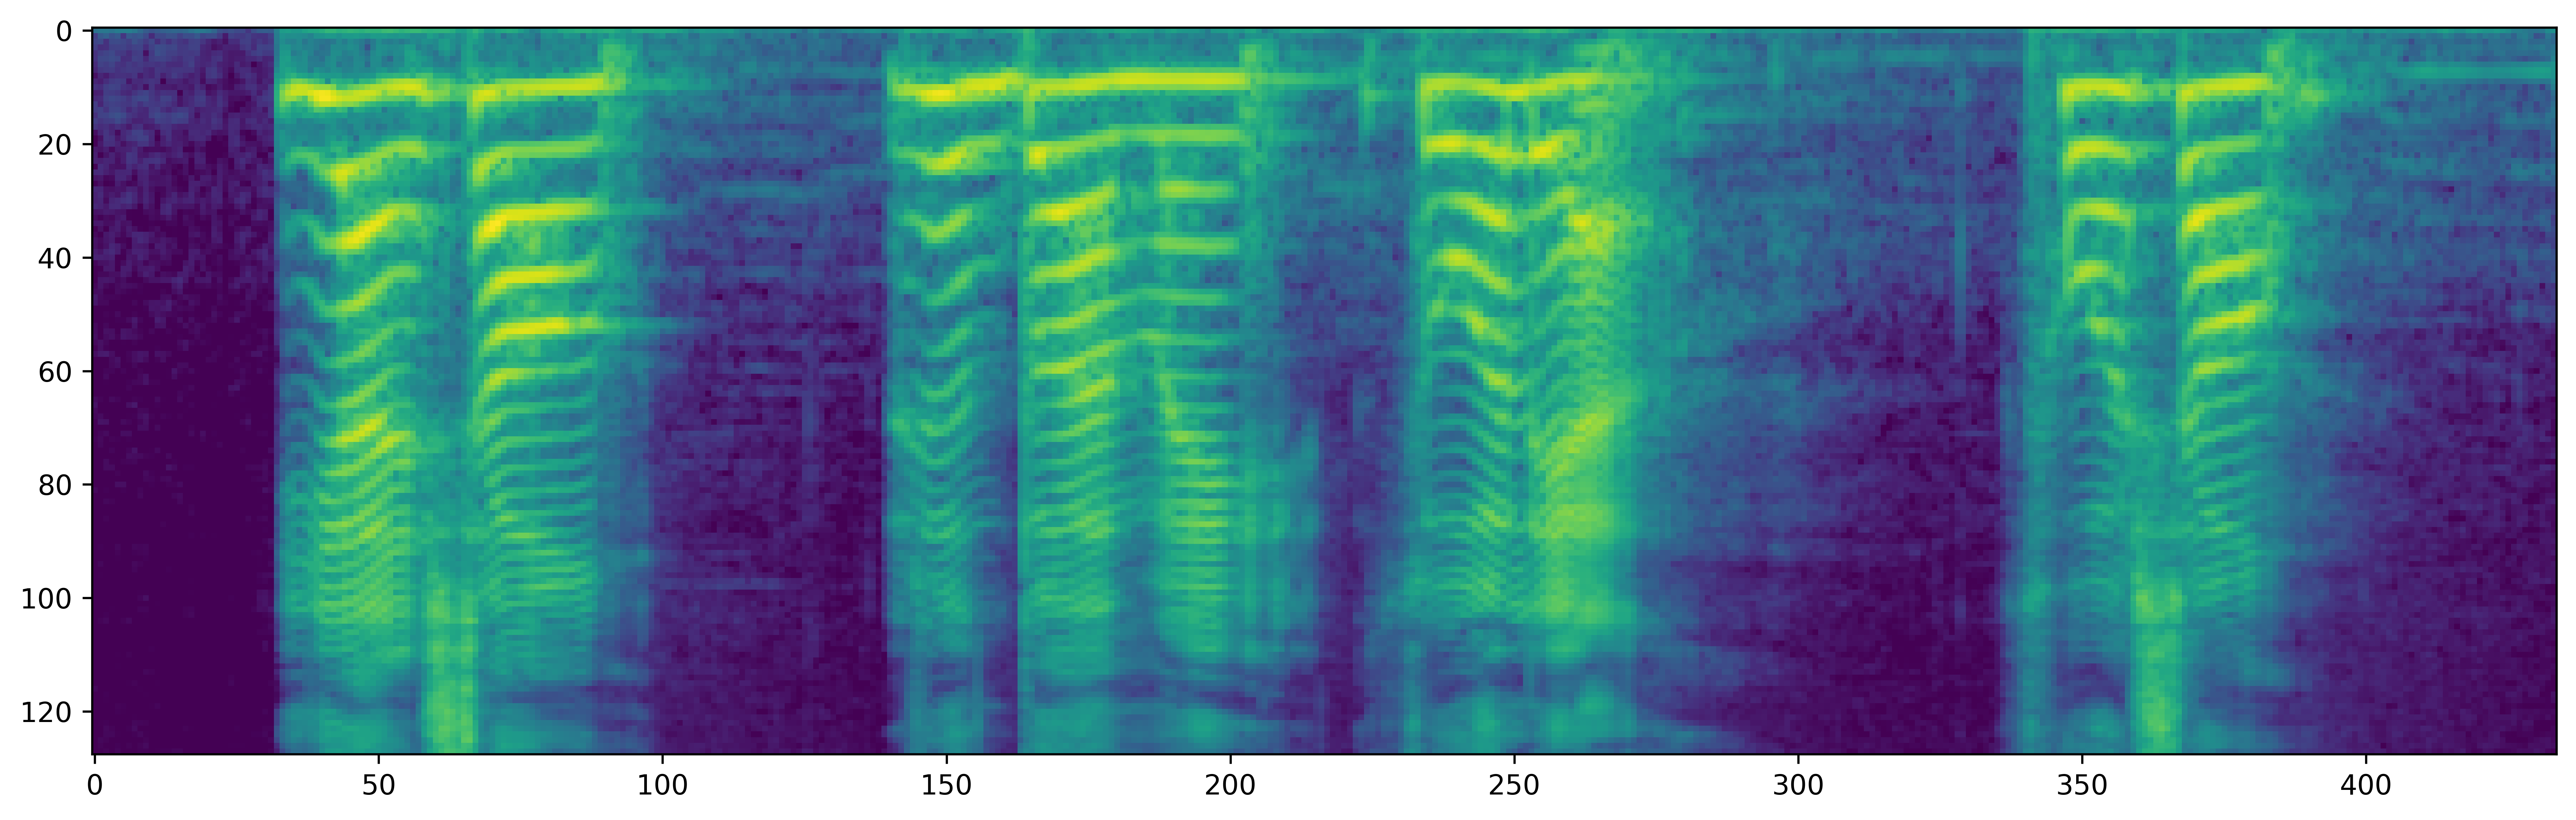

In [32]:
plt.figure(figsize=(16, 16),dpi=600)
plt.imshow(mel_s.T.squeeze(0).cpu())

In [42]:
torch.save(mel_s.squeeze(0).T, './00042.wav.pt')

#### Esitimate Valid

In [3]:
from Dataset.preparation import data_prepar_joint

In [65]:
test_files, test_labels = data_prepar_joint('Dataset/pitch_scaling_joint_seen_matlab.txt')

In [66]:
ast_mdl.train()
alpha_list, label_list = [], []
loss_fn = nn.MSELoss()
i = 0
since = time.time()
for wav, label in zip(test_files, test_labels):
    try:
        audio, sr = load_wav_to_torch(wav)
        mel = get_mel_a(audio, sr).unsqueeze(0).cuda()
        pred_alpha = ast_mdl(mel, task='ft_cls').detach().squeeze(0)
        # label = torch.tensor(test_labels[i]).unsqueeze(0).cuda()
        # loss = loss_fn(pred_alpha.float(), label.float())
        # loss_list.append(loss)
        alpha_list.append(pred_alpha)
        label_list.append(label)
        # i+=1
    except:
        print(wav)

time_elapsed = time.time() - since 
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
# loss_list_mean = sum(loss_list)/len(loss_list)

Testing complete in 4m 27s


In [67]:
label = torch.tensor(label_list).cuda()
alpha = torch.tensor(alpha_list).cuda()

In [68]:
err = (alpha - label).abs().mean()

In [69]:
err

tensor(0.4168, device='cuda:0')

In [9]:
err

tensor(1.3173, device='cuda:0')

In [10]:
len(alpha)

11055

In [53]:
len(label)

11066